In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
from sklearn import preprocessing 
import payments_manager as pm

#pm.help()
#pm.reset()
pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()
df_jo_cp['cr_received_date'] = df_jo_cp.cash_request_received_date


In [2]:
df = pm.df('df_jall')
#df = df_jo_cp

#display(df)
#display(df[~df.Mes_created_at.isna()])

# Tiempo que tarda en recibir el dinero el usuario desde la primera accion.
# cr_received_date  (cash_request_received_date) = ??
df['to_receive_ini'] = df.cr_received_date-df.created_at

# Tiempo que tarda en recibir el dinero el usuario desde que se envia.
df['to_receive_bank'] = df.cr_received_date-df.send_at

# Tiempo que la empresa recupera el dinero desde la primera accion.
df['to_reimbur'] = df.reimbursement_date-df.created_at

# Tiempo que la empresa presta el dinero.
df['to_end'] = df.reimbursement_date-df.money_back_date

#* Demora:
df['to_delay'] = df.money_back_date-df.reimbursement_date

# TransfType: instant send_at - created_at =? 0 dias
# TransfType: regular send_at - created_at =? 7 dias
df['to_send'] = df.send_at-df.created_at

df.info()
display(df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32094 non-null  int64          
 1   amount                      32094 non-null  float64        
 2   stat_cr                     32094 non-null  object         
 3   created_at                  32094 non-null  datetime64[ns] 
 4   updated_at_x                32094 non-null  datetime64[ns] 
 5   user_id                     32094 non-null  int64          
 6   active                      32094 non-null  int64          
 7   moderated_at                21759 non-null  datetime64[ns] 
 8   reimbursement_date          32094 non-null  datetime64[ns] 
 9   cash_request_received_date  24149 non-null  datetime64[ns] 
 10  money_back_date             23917 non-null  datetime64[ns] 
 11  transfer_type               32094 non-nul

,id_cr,amount,stat_cr,created_at,updated_at_x,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,...,to_date,charge_moment,fee,cr_received_date,to_receive_ini,to_receive_bank,to_reimbur,to_end,to_delay,to_send
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.407830,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999490,NaT,NaT,NaT
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,30 days 00:00:00,NaT,NaT,NaT
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999581,NaT,NaT,NaT
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,29 days 23:59:59.999434,NaT,NaT,NaT
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.340080,7686,1,2020-05-07 09:21:55.320193,2020-06-05 22:00:00.000000,NaT,...,NaT,NaN,NaN,NaT,NaT,NaT,30 days 12:00:21.122624,NaT,NaT,NaT


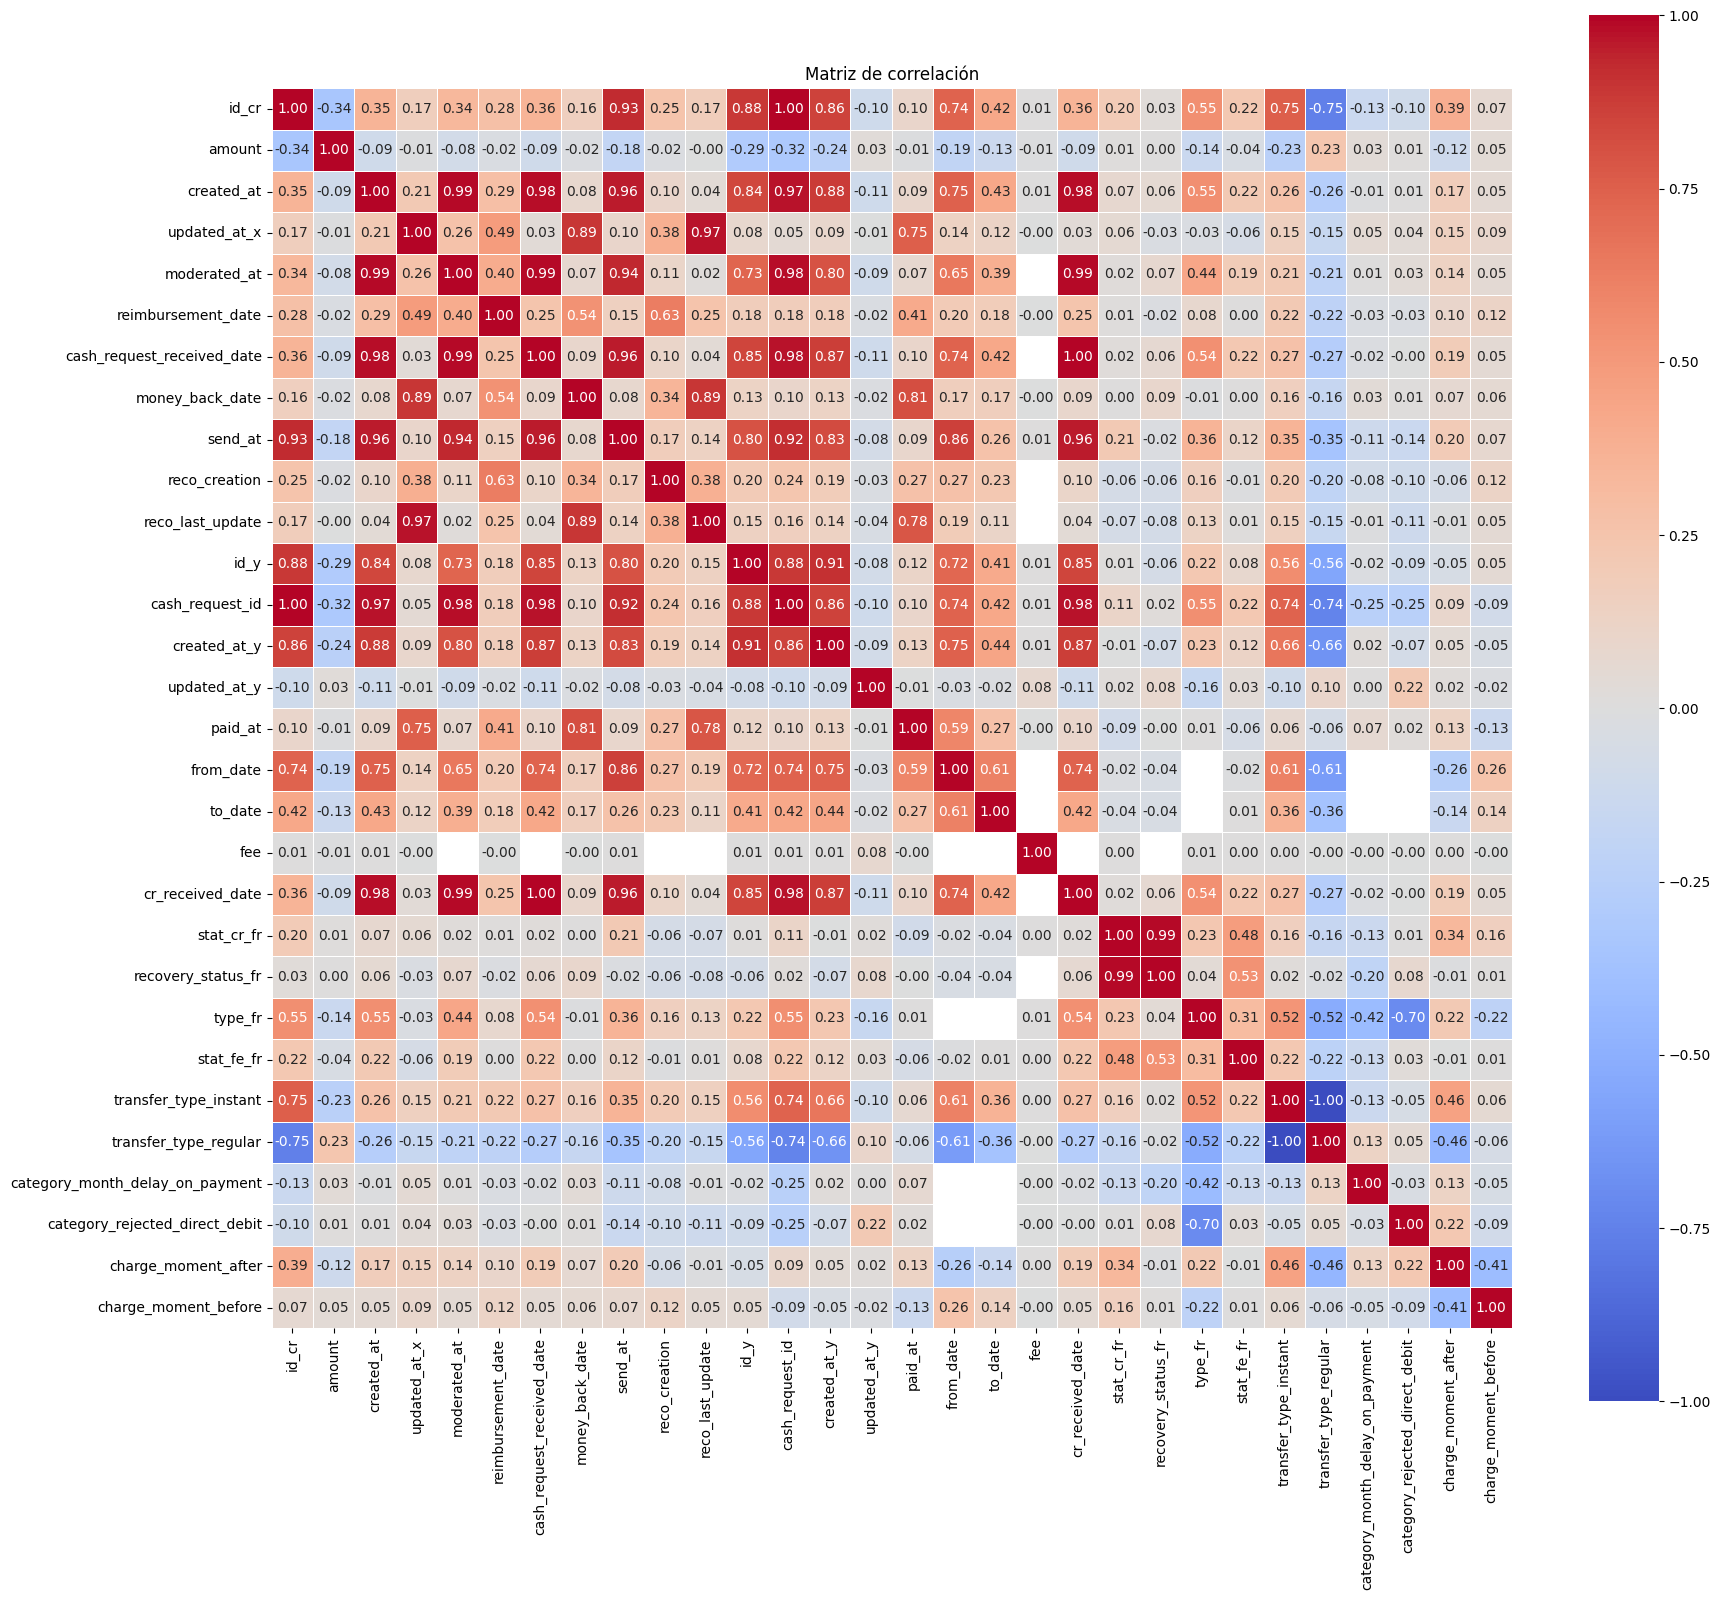

Variables altamente correlacionadas con otras:


['id_cr',
 'created_at',
 'updated_at_x',
 'moderated_at',
 'cash_request_received_date',
 'money_back_date',
 'send_at',
 'reco_last_update',
 'id_y',
 'cash_request_id',
 'created_at_y',
 'paid_at',
 'from_date',
 'cr_received_date',
 'stat_cr_fr',
 'recovery_status_fr',
 'transfer_type_instant',
 'transfer_type_regular']

In [5]:
df = pm.df('df_jall') #= pm.df('df_jo')
df = df.drop(columns=['active'])
df = df.drop(columns=['Mes_created_at'])
#df = df.drop(columns=['fee'])

df = df.drop(columns=['user_id'])
df = df.drop(columns=['total_amount'])

d_list = list(df.select_dtypes(include=['datetime64']).columns)
for date in d_list:
    df[date] = pd.to_datetime(df[date]).dt.strftime('%Y%m%d').astype(float)

# Encode labels
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()   
# df['type_lb']= label_encoder.fit_transform(df['type'])   
# df['type'].unique() 
# df['stat_fe_lb']= label_encoder.fit_transform(df['stat_fe'])   
# df['stat_fe'].unique() 
# #a[pd.isnull(a)]  = 'NaN'
# df['charge_moment_lb']= label_encoder.fit_transform(df['charge_moment'])   
# df['charge_moment_lb'].unique() 
df['stat_cr_fr'] = df['stat_cr'].map(df['stat_cr'].value_counts())
#df['transfer_type_fr'] = df['transfer_type'].map(df['transfer_type'].value_counts())
df_categ = pd.get_dummies(df['transfer_type'], prefix="transfer_type")
df = pd.concat([df, df_categ], axis=1)

df['recovery_status_fr'] = df['recovery_status'].map(df['recovery_status'].value_counts())

df['type_fr'] = df['type'].map(df['type'].value_counts())
df['stat_fe_fr'] = df['stat_fe'].map(df['stat_fe'].value_counts())
#df['charge_moment_fr'] = df['charge_moment'].map(df['charge_moment'].value_counts())
#df['category_fr'] = df['category'].map(df['category'].value_counts())
df_categ = pd.get_dummies(df['category'], prefix="category")
df = pd.concat([df, df_categ], axis=1)
df_categ = pd.get_dummies(df['charge_moment'], prefix="charge_moment")
df = pd.concat([df, df_categ], axis=1)
#display(df)

df_corr = df.select_dtypes(include=['number'])
df_bool = df.select_dtypes(include=['bool'])
df_corr = pd.concat([df_corr, df_bool], axis=1)

matriz_corr = df_corr.corr()
plt.figure(figsize=(20, 18)) 
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

# Identificar columnas con correlación alta (umbral = 0.8)
threshold = 0.8
to_drop = []
for column in matriz_corr.columns:
    if any((matriz_corr[column].abs() > threshold) & (matriz_corr.index != column)):
        to_drop.append(column)
        
print(f"Variables altamente correlacionadas con otras:")
display(to_drop)